In [1]:
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork
from FlowStability import FlowIntegralClustering
import numpy as np
import time
import matplotlib.pyplot as plt

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


# Example of temporal network with asymmetric temporal paths (Fig. 2)


In [2]:
inter_tau = 1
activ_tau = 1
t_start = 0
n_groups = 3
n_per_group = 9
individuals = []


m1=0.95
p1=0.95
deltat1 =120
deltat2=40

t_end = 3*deltat1+2*deltat2




def make_step_block_probs(deltat1, deltat2, m1=1, p1=1):
    """ Returns a function that generate the block probability matrix as a function of time.
    
        `deltat1` is the length of the within step
    
        `deltat2` is the length of the echanging step
        
        `m1` is the prob of self-interaction (during deltat1)
        
        `p1` is the prob of cross-interaction (during deltat2)
    """


    def block_mod_func(t):
        
        m2 = (1-m1)/2
        p2 = (1-p1)
        
        ex12 = np.array([[p2,p1,0],
                         [p1,p2,0],
                         [0,0,1]])
        ex23 = np.array([[1,0,0],
                         [0,p2,p1],
                         [0,p1,p2]])
        ex13 = np.array([[p2,0,p1],
                         [0, 1, 0],
                         [p1,0,p2]])
    
        I = np.array([[m1,m2,m2],
                      [m2,m1,m2],
                      [m2,m2,m1]])
        if t>=0 and  t < deltat1:
            return ex12
        elif t>=deltat1 and t<deltat1+deltat2:
            return I
        elif t>=deltat1+deltat2 and t < 2*deltat1+deltat2:
            return ex23
        elif t>= 2*deltat1+deltat2 and t < 2*(deltat1+deltat2):
            return I
        elif t>= 2*(deltat1+deltat2) and t < 2*(deltat1+deltat2)+deltat1:
            return ex13
        else:
            print('Warning : t must be >=0 and <= 3*deltat1+2*deltat2' +\
                  't is ', t)
            return I
        
    return block_mod_func
 


block_prob_mod_func = make_step_block_probs(deltat1,deltat2,m1,p1)


In [3]:
# create agents for the simlation
for g in range(n_groups):

    individuals.extend([Individual(i, inter_distro_scale=inter_tau,
                                      activ_distro_scale=activ_tau,
                                      group=g) for i in range(g*n_per_group,(g+1)*n_per_group)])

In [4]:
# run simulation
sim = SynthTempNetwork(individuals=individuals, t_start=t_start, t_end=t_end,
                       next_event_method='block_probs_mod',
                       block_prob_mod_func=block_prob_mod_func)

print('running simulation')
t0 = time.time()
sim.run(save_all_states=True, save_dt_states=True, verbose=False)
print(f'done in {time.time()-t0:.2f}s')


running simulation
done in 2.59s


## Creating a continuous time temporal network

In [5]:
# creating a temporal network from the simulation's result
net = ContTempNetwork(source_nodes=sim.indiv_sources,
                      target_nodes=sim.indiv_targets,
                      starting_times=sim.start_times,
                      ending_times=sim.end_times,
                      merge_overlapping_events=True)

PID  799  :  merged  1206  events
PID  799  :  merged  0  events


In [6]:
# the events of the temporal network are saved in a pandas dataframe in net.events_table
net.events_table

,source_nodes,target_nodes,starting_times,ending_times,durations
0,10,6,0.053432,0.123008,0.069575
1,15,3,0.059898,0.407326,0.347428
2,1,7,0.079514,1.320722,1.241208
3,15,1,0.087399,1.086838,0.999439
4,19,24,0.220005,0.517103,0.297098
...,...,...,...,...,...
10604,9,11,439.357996,439.794580,0.436583
10605,22,5,439.427799,439.817810,0.390011
10606,22,1,439.545832,439.613435,0.067603
10607,2,22,439.609473,439.791052,0.181578


In [7]:
# all the event times (starts and ends) are saved in 
net.times

Index([0.05343236109228204, 0.05989806283166913, 0.07951447626342917,
       0.08739924284361023, 0.12300765023349457,  0.2200048721966884,
       0.25266769683219675,  0.2897541271886314, 0.38664340549948734,
         0.407326042129514,
       ...
        439.83788731560475,   439.8483232241216,  439.84957883890155,
         439.8806934109208,   439.8991850070493,  439.89923886970774,
        439.90331754876513,  439.92798688530644,  439.94945843827225,
         439.9551989438452],
      dtype='float64', name='times', length=21218)

In [8]:
# Compute inter transition matrices. 
# lamda is random walk rate.
# By default, the matrix exponential is computed using the version of the algorithm for dense matrices (scipy expm), 
# which is faster but only works for small networks. 
# To use the sparse implementation, set `dense_expm=False`

lamda=1/10
t0 = time.time()
net.compute_inter_transition_matrices(lamda=lamda, verbose=True)
print(f'done in {time.time()-t0:.2f}s')

PID  799  :  Computing Laplacians
PID  799  :  0  over  21217
PID 799 : 0.00s
PID  799  :  1000  over  21217
PID 799 : 0.50s
PID  799  :  2000  over  21217
PID 799 : 0.98s
PID  799  :  3000  over  21217
PID 799 : 1.47s
PID  799  :  4000  over  21217
PID 799 : 1.97s
PID  799  :  5000  over  21217
PID 799 : 2.48s
PID  799  :  6000  over  21217
PID 799 : 2.97s
PID  799  :  7000  over  21217
PID 799 : 3.46s
PID  799  :  8000  over  21217
PID 799 : 3.96s
PID  799  :  9000  over  21217
PID 799 : 4.43s
PID  799  :  10000  over  21217
PID 799 : 4.93s
PID  799  :  11000  over  21217
PID 799 : 5.41s
PID  799  :  12000  over  21217
PID 799 : 5.91s
PID  799  :  13000  over  21217
PID 799 : 6.41s
PID  799  :  14000  over  21217
PID 799 : 6.88s
PID  799  :  15000  over  21217
PID 799 : 7.36s
PID  799  :  16000  over  21217
PID 799 : 7.85s
PID  799  :  17000  over  21217
PID 799 : 8.36s
PID  799  :  18000  over  21217
PID 799 : 8.84s
PID  799  :  19000  over  21217
PID 799 : 9.33s
PID  799  :  20000 

In [9]:
# the matrices are saved in a list here
net.inter_T[lamda]
# where net.inter_T[lamda][k] is the probability transition matrix
# between net.times[k] and net.times[k+1]

[<27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 29 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 31 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 33 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 41 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 39 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 41 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 49 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 59 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 61 stored

In [32]:
# the temporal network can be saved, togheter with the inter-event transition matrices in a pickle file:
net.save('example_network')


In [33]:
# and can be loaded unsing `ContTempNetwork.load`
net2 = ContTempNetwork.load('example_network')


## Computing the covariance integral

In [10]:
# We can now compute the integral of the covariance using FlowIntegralClustering.
# We need to give the inter-event transition matrices, the inter-event times and 
# a list of times until which to compute the integral is computed.

integral_time_grid = np.linspace(0, t_end, 12, endpoint=True)

I_forw = FlowIntegralClustering(T_inter_list=[T.toarray() for T in net.inter_T[lamda]], 
                                time_list=net.times,
                                integral_time_grid=integral_time_grid,
                                verbose=True)

PID  799  : computing T_list
PID  799  : computing integral
PID  799  :  0  over  21217  took 0.00s
PID  799  :  1000  over  21217  took 0.01s
PID  799  :  2000  over  21217  took 0.01s
PID  799  :  3000  over  21217  took 0.01s
PID  799  :  4000  over  21217  took 0.01s
PID  799  :  5000  over  21217  took 0.01s
PID  799  :  6000  over  21217  took 0.01s
PID  799  :  7000  over  21217  took 0.01s
PID  799  :  8000  over  21217  took 0.01s
PID  799  :  9000  over  21217  took 0.01s
PID  799  :  10000  over  21217  took 0.01s
PID  799  :  11000  over  21217  took 0.01s
PID  799  :  12000  over  21217  took 0.01s
PID  799  :  13000  over  21217  took 0.01s
PID  799  :  14000  over  21217  took 0.01s
PID  799  :  15000  over  21217  took 0.01s
PID  799  :  16000  over  21217  took 0.01s
PID  799  :  17000  over  21217  took 0.01s
PID  799  :  18000  over  21217  took 0.01s
PID  799  :  19000  over  21217  took 0.01s
PID  799  :  20000  over  21217  took 0.01s
PID  799  :  21000  over  212

In [11]:
# The list of transition matrices are stored in I_forw.T_list
# where I_forw.T_list[k] contains the transition matrix between net.times[0] and net.times[k+1]

I_forw.T_list[10]

array([[9.78683184e-01, 9.51121203e-05, 0.00000000e+00, 3.92541426e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.02414291e-07,
        0.00000000e+00, 2.01027718e-07, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.11820461e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.01237049e-04, 9.62328854e-01, 0.00000000e+00, 8.98505073e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.62421642e-02,
        0.00000000e+00, 5.75210304e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.54857909e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00

In [12]:
# The autocovariance integrals are stored in I_forw.I_list
# I_forw.I_list[k] contains the integral of the autocovariance 
# from I_forw._t_integral_grid[0] to I_forw._t_integral_grid[k+1]

I_forw.I_list[3]

array([[ 0.0020209 ,  0.00059704,  0.00055446,  0.00055527,  0.00049971,
         0.00052552,  0.00047989,  0.00053486,  0.00052622,  0.00071559,
         0.00048443,  0.00048564,  0.00055364,  0.00079027,  0.00054749,
         0.00094651,  0.00054204,  0.0004697 , -0.00131435, -0.00131435,
        -0.00131435, -0.00131435, -0.00131435, -0.00131435, -0.00131435,
        -0.00131435, -0.00131435],
       [ 0.00059704,  0.00168546,  0.00056359,  0.00051648,  0.00051055,
         0.00053234,  0.00052294,  0.00069696,  0.00053538,  0.00065107,
         0.00054503,  0.00075424,  0.00052293,  0.00086575,  0.00058235,
         0.00068043,  0.00049919,  0.00056747, -0.00131435, -0.00131435,
        -0.00131435, -0.00131435, -0.00131435, -0.00131435, -0.00131435,
        -0.00131435, -0.00131435],
       [ 0.00055446,  0.00056359,  0.00214521,  0.00049518,  0.00053978,
         0.00056561,  0.00053673,  0.00050289,  0.00057011,  0.00068939,
         0.00047769,  0.00075942,  0.00050043,  0.0005

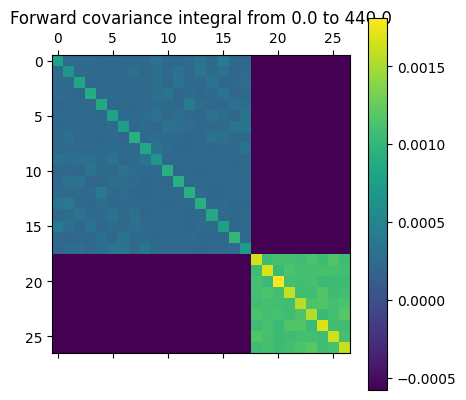

In [13]:
plt.matshow(I_forw.I_list[10])
plt.colorbar()
_ =  plt.title(f'Forward covariance integral from {I_forw.integral_time_grid[0]} to {I_forw.integral_time_grid[11]}')


In [14]:
# similarly, we can compute the backward covariance integral, by reversing time.
I_back = FlowIntegralClustering(T_inter_list=[T.toarray() for T in net.inter_T[lamda]], 
                                time_list=net.times,
                                integral_time_grid=integral_time_grid,
                                reverse_time=True,
                                verbose=True)

PID  799  : computing T_list
PID  799  : computing integral
PID  799  :  0  over  21217  took 0.00s
PID  799  :  1000  over  21217  took 0.01s
PID  799  :  2000  over  21217  took 0.01s
PID  799  :  3000  over  21217  took 0.01s
PID  799  :  4000  over  21217  took 0.01s
PID  799  :  5000  over  21217  took 0.01s
PID  799  :  6000  over  21217  took 0.01s
PID  799  :  7000  over  21217  took 0.01s
PID  799  :  8000  over  21217  took 0.01s
PID  799  :  9000  over  21217  took 0.01s
PID  799  :  10000  over  21217  took 0.01s
PID  799  :  11000  over  21217  took 0.01s
PID  799  :  12000  over  21217  took 0.01s
PID  799  :  13000  over  21217  took 0.01s
PID  799  :  14000  over  21217  took 0.01s
PID  799  :  15000  over  21217  took 0.01s
PID  799  :  16000  over  21217  took 0.01s
PID  799  :  17000  over  21217  took 0.01s
PID  799  :  18000  over  21217  took 0.01s
PID  799  :  19000  over  21217  took 0.01s
PID  799  :  20000  over  21217  took 0.01s
PID  799  :  21000  over  212

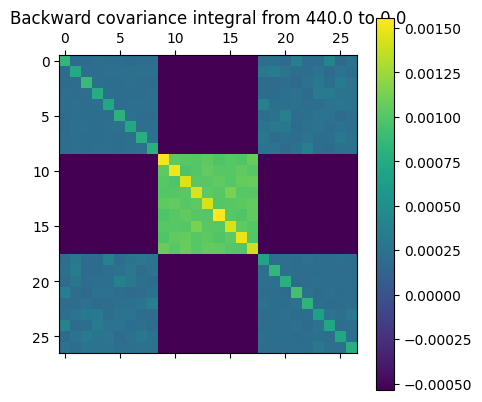

In [15]:
plt.matshow(I_back.I_list[10])
plt.colorbar()
_ = plt.title(f'Backward covariance integral from {I_back.integral_time_grid[0]} to {I_back.integral_time_grid[11]}')


## Optimizing the flow stability to find the best partition

In [16]:
# we can now find the partition optimizing the flow stability, 
# i.e. best clustering the covariance integral, with the Louvain algorithm
I_forw.find_louvain_clustering(k=10)

2

In [17]:
# the result is saved in 
I_forw.partition[10]
# and is a `Partition` object 

Partition with 27 nodes and 2 clusters.

In [18]:
# the cluster list is stored in 
I_forw.partition[10].cluster_list

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17},
 {18, 19, 20, 21, 22, 23, 24, 25, 26}]

In [19]:
# a dictionary mapping node ids to cluster ids is also availiable
I_forw.partition[10].node_to_cluster_dict

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1}

In [20]:
# Similarly for the backward flow stability
I_back.find_louvain_clustering(k=10)


2

In [21]:
I_back.partition[10].cluster_list

[{9, 10, 11, 12, 13, 14, 15, 16, 17},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26}]